# **Import**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
main_dir = '/content/drive/MyDrive/Colab Notebooks/NTC'

In [3]:
%cd $main_dir
!ls

/content/drive/MyDrive/Colab Notebooks/NTC
Custom_Flower_FL.ipynb	flower_saved


In [4]:
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 38.1 MB/s eta 0:00:00


In [5]:
# !pip install --upgrade --index-url https://pypi.ngc.nvidia.com nvidia-tensorrt

In [6]:
# import tensorrt as trt
# trt.__version__

In [7]:
from collections import OrderedDict
from typing import List, Tuple

from pathlib import Path
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, random_split

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU, "cpu" to train on CPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.1+cu118 and Flower 1.4.0


# **Loading dataset**

In [ ]:
byte_number = "256"
experiment_name = "GQUIC_small_" + byte_number
method = "Flower_FL_CNN2D"

PACKET_NUM = 20
NUM_FEATURE = int(byte_number)
NUM_CLASSES = 5

client_lr = 0.0001
BATCH_SIZE = 32
NUM_ROUNDS = 48
NUM_CLIENTS = 10

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/FL/GQUIC_small/Train/GQUIC_train_' + byte_number + '.feather'
test_dir = '/content/drive/MyDrive/Colab Notebooks/FL/GQUIC_small/Test/GQUIC_test_' + byte_number + '.feather'
data = pd.read_feather(train_dir)
test = pd.read_feather(test_dir)

In [ ]:
def most_frequent(List):
    return max(set(List), key=List.count)

In [ ]:
def load_data_set(data):
  flows = data.groupby('flow_id')['Label'].apply(list).to_dict()
  true_label = []
  for flow in flows:
    true_label.append(most_frequent(flows[flow]))

  true_label = np.array(true_label)
  true_dataset = data.drop(['Label', 'flow_id'], axis=1).to_numpy()/255
  true_dataset = true_dataset.reshape(-1, PACKET_NUM, NUM_FEATURE)
  true_dataset = np.expand_dims(true_dataset, -1)

  true_set = []
  for i in range(true_dataset.shape[0]):
    true_set.append(true_dataset[i].transpose(2, 0, 1))

  true_set = np.array(true_set)
  return true_set, true_label

In [ ]:
x_train, y_train = load_data_set(data)
x_test, y_test = load_data_set(test)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(13166, 1, 20, 256)
(13166,)


In [ ]:
def crop(x_train, y_train):
  exceed = x_train.shape[0] % NUM_CLIENTS
  length = x_train.shape[0] - exceed
  x_train = x_train[:length]
  y_train = y_train[:length]

  return x_train, y_train

In [ ]:
x_train, y_train = crop(x_train, y_train)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(13160, 1, 20, 256)
(13160,)


In [ ]:
def to_tensor(x_train, y_train):
  tensor_x = torch.Tensor(x_train) # transform to torch tensor
  tensor_y = torch.Tensor(y_train)
  tensor_y = tensor_y.type(torch.LongTensor)

  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  return my_dataset

In [ ]:
train_set = to_tensor(x_train, y_train)
test_set = to_tensor(x_test, y_test)

In [ ]:
def load_datasets():
    # Split training set into 10 partitions to simulate the individual dataset
    partition_size = len(train_set) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    datasets = random_split(train_set, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(test_set, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()

# **Model**

In [ ]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, (5, 5), padding=(2, 2))
        self.conv2 = nn.Conv2d(32, 32, (5, 5), padding=(2, 2))
        self.pool1 = nn.MaxPool2d((2, 2))
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.conv4 = nn.Conv2d(64, 64, (3, 3), padding=(1, 1))
        self.pool2 = nn.MaxPool2d((2, 2), (2, 2))
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 5 * 64, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, NUM_CLASSES)
        self.softmax = nn.Softmax(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x

In [ ]:
net = Net().to(DEVICE)

In [ ]:
summary(net, (1, PACKET_NUM, NUM_FEATURE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 20, 256]             832
            Conv2d-2          [-1, 32, 20, 256]          25,632
         MaxPool2d-3          [-1, 32, 10, 128]               0
           Dropout-4          [-1, 32, 10, 128]               0
            Conv2d-5          [-1, 64, 10, 128]          18,496
            Conv2d-6          [-1, 64, 10, 128]          36,928
         MaxPool2d-7            [-1, 64, 5, 64]               0
           Dropout-8            [-1, 64, 5, 64]               0
            Linear-9                  [-1, 256]       5,243,136
          Dropout-10                  [-1, 256]               0
           Linear-11                    [-1, 5]           1,285
          Softmax-12                    [-1, 5]               0
Total params: 5,326,309
Trainable params: 5,326,309
Non-trainable params: 0
---------------------------

# **Train**

In [ ]:
def train(net, trainloader, train_time, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=client_lr)
    net.train()
    data_iter = iter(trainloader)
    total, total_loss, correct = 0, 0.0, 0
    start = time()
    while True:
      if time() - start > train_time:
        break
      try:
        images, labels = next(data_iter)
      except StopIteration:
        # StopIteration is thrown if dataset ends
        # Reinitialize data_iter
        data_iter = iter(trainloader)
        images, labels = next(data_iter)

      # Train parameters
      images, labels = images.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Metric
      total += labels.size(0)
      total_loss += loss
      _, predicted = torch.max(outputs.data, 1)
      correct += (predicted == labels).sum().item()
    return total_loss / total, correct / total

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

### **Training centralized**

In [ ]:
# trainloader = trainloaders[0]
# valloader = valloaders[0]
# net = Net().to(DEVICE)

# train(net, trainloader, 60)
# loss, accuracy = test(net, valloader)
# print(f"Train: validation loss {loss}, accuracy {accuracy}")

# loss, accuracy = test(net, testloader)
# print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

# **Federated Learning**

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = train(self.net, self.trainloader, train_time=config["train_time"])
        return get_parameters(self.net), len(self.trainloader), {"loss": float(loss), "accuracy": float(accuracy)}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader)

### **Variables**

In [ ]:
val_loss = []
val_acc = []
train_loss = []
train_acc = []
first_train_loss = []
first_val_loss = []

### **Custom flower federated learning**

In [ ]:
from flwr.common import FitIns

In [ ]:
class CustomStrategy(fl.server.strategy.FedAvg):
  train_time = 5

  def aggregate_fit(
      self,
      server_round: int,
      results,
      failures,
  ):
    parameters_aggregated, _ = super().aggregate_fit(server_round, results, failures)
    print("Training round {}".format(server_round))
    return parameters_aggregated, {}

  def aggregate_evaluate(
      self,
      server_round: int,
      results,
      failures,
  ):
    loss_aggregated, metrics_aggregated = super().aggregate_evaluate(server_round, results, failures)
    _, evaluate_res = results[0]
    first_val_loss.append(evaluate_res.loss)
    val_loss.append(loss_aggregated)
    print("Evaluate round {}".format(server_round))
    return loss_aggregated, metrics_aggregated

  def configure_fit(
      self, server_round: int, parameters, client_manager
  ):
    config = {"train_time": self.train_time}
    fit_ins = FitIns(parameters, config)

    # Sample clients
    sample_size, min_num_clients = self.num_fit_clients(
        client_manager.num_available()
    )
    clients = client_manager.sample(
        num_clients=sample_size, min_num_clients=min_num_clients
    )

    # Return client/config pairs
    return [(client, fit_ins) for client in clients]

In [ ]:
def fit_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    _, first_loss = metrics[0]
    first_train_loss.append(first_loss['loss'])
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    loss = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    acc = sum(accuracies) / sum(examples)
    loss = sum(loss) / sum(examples)
    train_loss.append(loss)
    train_acc.append(acc)
    # Aggregate and return custom metric (weighted average)
    return {}

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    acc = sum(accuracies) / sum(examples)
    val_acc.append(acc)
    # Aggregate and return custom metric (weighted average)
    return {"accuracy": acc}

### **Train federated learning**

In [ ]:
# Create FedAvg strategy
strategy = CustomStrategy(
    fraction_fit=0.8,  # Sample 80% of available clients for training
    fraction_evaluate=0.8,  # Sample 80% of available clients for evaluation
    min_fit_clients=8,  # Never sample less than 8 clients for training
    min_evaluate_clients=8,  # Never sample less than 8 clients for evaluation
    min_available_clients=10,  # Wait until all 8 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
    fit_metrics_aggregation_fn=fit_weighted_average
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

2023-07-30 05:44:03,922	INFO worker.py:1621 -- Started a local Ray instance.
(pid=5431) 2023-07-30 05:44:10.881762: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=5514) 2023-07-30 05:44:20.437410: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=5585) 2023-07-30 05:44:32.397967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=5659) 2023-07-30 05:44:46.082698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=5745) 2023-07-30 05:44:57.247920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=5825) 2023-07-30 05:45:10.788240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=5903) 2023-07-30 05:45:22.715995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Training round 1


(pid=6157) 2023-07-30 05:46:03.595930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6212) 2023-07-30 05:46:12.818225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6267) 2023-07-30 05:46:19.058805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6324) 2023-07-30 05:46:28.018909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6375) 2023-07-30 05:46:33.966667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6428) 2023-07-30 05:46:42.971192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6489) 2023-07-30 05:46:49.238881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6546) 2023-07-30 05:46:59.789130: W tensorflow/com

Evaluate round 1


(pid=6621) 2023-07-30 05:47:09.370884: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6701) 2023-07-30 05:47:21.515796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6771) 2023-07-30 05:47:34.901710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6849) 2023-07-30 05:47:47.213509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=6941) 2023-07-30 05:48:00.662227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7019) 2023-07-30 05:48:13.184684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7091) 2023-07-30 05:48:25.534818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7165) 2023-07-30 05:48:38.361725: W tensorflow/com

Training round 2


(pid=7267) 2023-07-30 05:48:54.605386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7328) 2023-07-30 05:49:02.192692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7379) 2023-07-30 05:49:09.765148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7440) 2023-07-30 05:49:17.883321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7491) 2023-07-30 05:49:24.472977: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7552) 2023-07-30 05:49:33.076618: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7599) 2023-07-30 05:49:39.303552: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7656) 2023-07-30 05:49:48.404873: W tensorflow/com

Evaluate round 2


(pid=7731) 2023-07-30 05:49:57.207448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7805) 2023-07-30 05:50:09.975334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7881) 2023-07-30 05:50:22.544460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=7955) 2023-07-30 05:50:35.744922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8039) 2023-07-30 05:50:47.404545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8121) 2023-07-30 05:51:00.356134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8191) 2023-07-30 05:51:12.433867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8267) 2023-07-30 05:51:25.693996: W tensorflow/com

Training round 3


(pid=8365) 2023-07-30 05:51:42.314697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8430) 2023-07-30 05:51:49.956097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8481) 2023-07-30 05:51:58.291440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +10m51s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +10m51s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=8546) 2023-07-30 05:52:06.414734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8599) 2023-07-30 05:52:13.408371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8662) 2023-07-30 05:52:22.250672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8713) 2023-07-30 05:52:28.674744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8774) 2023-07-30 05:52:37.506811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Evaluate round 3


(pid=8837) 2023-07-30 05:52:47.569069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8923) 2023-07-30 05:53:00.399331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=8999) 2023-07-30 05:53:13.145749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9069) 2023-07-30 05:53:25.787617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9145) 2023-07-30 05:53:38.922601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9221) 2023-07-30 05:53:50.911716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9301) 2023-07-30 05:54:03.544144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9369) 2023-07-30 05:54:16.017018: W tensorflow/com

Training round 4


(pid=9467) 2023-07-30 05:54:32.050563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9522) 2023-07-30 05:54:38.639377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9573) 2023-07-30 05:54:48.181734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9636) 2023-07-30 05:54:54.359325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9683) 2023-07-30 05:55:03.269998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9742) 2023-07-30 05:55:09.870433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9789) 2023-07-30 05:55:18.161347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=9856) 2023-07-30 05:55:25.830986: W tensorflow/com

Evaluate round 4


(pid=9917) 2023-07-30 05:55:37.182567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10001) 2023-07-30 05:55:49.548126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10081) 2023-07-30 05:56:02.956162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10157) 2023-07-30 05:56:14.662836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10227) 2023-07-30 05:56:28.336289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10303) 2023-07-30 05:56:40.102392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10385) 2023-07-30 05:56:53.294839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10463) 2023-07-30 05:57:05.845678: W tensorf

Training round 5


(pid=10549) 2023-07-30 05:57:20.882368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10602) 2023-07-30 05:57:27.321599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10657) 2023-07-30 05:57:36.694695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10708) 2023-07-30 05:57:42.851741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10759) 2023-07-30 05:57:52.252970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10822) 2023-07-30 05:57:58.583543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10869) 2023-07-30 05:58:07.861395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=10928) 2023-07-30 05:58:14.277885: W tensor

Evaluate round 5


(pid=10997) 2023-07-30 05:58:25.835007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11075) 2023-07-30 05:58:39.365396: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11155) 2023-07-30 05:58:51.937356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11239) 2023-07-30 05:59:04.921200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11307) 2023-07-30 05:59:16.890939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11381) 2023-07-30 05:59:29.999449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11457) 2023-07-30 05:59:41.355615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11533) 2023-07-30 05:59:54.743572: W tensor

Training round 6


(pid=11627) 2023-07-30 06:00:09.265700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11676) 2023-07-30 06:00:16.048922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11735) 2023-07-30 06:00:24.786303: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11784) 2023-07-30 06:00:30.798972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11839) 2023-07-30 06:00:39.708748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11890) 2023-07-30 06:00:45.502530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=11941) 2023-07-30 06:00:54.639515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12000) 2023-07-30 06:01:01.065607: W tensor

Evaluate round 6


(pid=12069) 2023-07-30 06:01:12.605278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12145) 2023-07-30 06:01:25.882445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12227) 2023-07-30 06:01:38.331702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12303) 2023-07-30 06:01:50.522450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12375) 2023-07-30 06:02:02.838089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12447) 2023-07-30 06:02:16.328446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12529) 2023-07-30 06:02:27.967122: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12605) 2023-07-30 06:02:41.427590: W tensor

Training round 7


(pid=12691) 2023-07-30 06:02:55.885643: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12746) 2023-07-30 06:03:02.612685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12801) 2023-07-30 06:03:10.914750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12852) 2023-07-30 06:03:16.975434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12903) 2023-07-30 06:03:25.812772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=12956) 2023-07-30 06:03:31.866031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13007) 2023-07-30 06:03:40.197582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13062) 2023-07-30 06:03:46.815697: W tensor

Evaluate round 7


(pid=13123) 2023-07-30 06:03:58.241067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13211) 2023-07-30 06:04:10.598890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13291) 2023-07-30 06:04:23.473983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13365) 2023-07-30 06:04:35.237000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13433) 2023-07-30 06:04:48.389123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13507) 2023-07-30 06:04:59.450605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13589) 2023-07-30 06:05:12.690812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13657) 2023-07-30 06:05:24.242217: W tensor

Training round 8


(pid=13745) 2023-07-30 06:05:39.813818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13800) 2023-07-30 06:05:46.017096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13851) 2023-07-30 06:05:55.347850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13908) 2023-07-30 06:06:01.425512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=13957) 2023-07-30 06:06:09.847622: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14016) 2023-07-30 06:06:16.659110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14067) 2023-07-30 06:06:23.587532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14124) 2023-07-30 06:06:31.790030: W tensor

Evaluate round 8


(pid=14189) 2023-07-30 06:06:42.562992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14269) 2023-07-30 06:06:54.677441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14349) 2023-07-30 06:07:07.785469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14417) 2023-07-30 06:07:19.763285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14491) 2023-07-30 06:07:32.489133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14567) 2023-07-30 06:07:44.172358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14643) 2023-07-30 06:07:56.683089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14715) 2023-07-30 06:08:09.764436: W tensor

Training round 9


(pid=14809) 2023-07-30 06:08:26.784298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14870) 2023-07-30 06:08:33.904695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14929) 2023-07-30 06:08:44.056582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=14984) 2023-07-30 06:08:50.516508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15035) 2023-07-30 06:09:00.164333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15096) 2023-07-30 06:09:06.453835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15149) 2023-07-30 06:09:15.859954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15208) 2023-07-30 06:09:22.461808: W tensor

Evaluate round 9


(pid=15275) 2023-07-30 06:09:34.301890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15355) 2023-07-30 06:09:47.431056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15439) 2023-07-30 06:10:00.708434: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15519) 2023-07-30 06:10:13.477993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15587) 2023-07-30 06:10:25.883232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15661) 2023-07-30 06:10:39.373495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15741) 2023-07-30 06:10:51.427656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15823) 2023-07-30 06:11:05.279353: W tensor

Training round 10


(pid=15915) 2023-07-30 06:11:20.282658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=15966) 2023-07-30 06:11:29.006907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16031) 2023-07-30 06:11:37.873204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16082) 2023-07-30 06:11:45.681645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16145) 2023-07-30 06:11:54.342300: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16196) 2023-07-30 06:12:02.057866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16263) 2023-07-30 06:12:11.632676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16314) 2023-07-30 06:12:20.054668: W tensor

Evaluate round 10


(pid=16395) 2023-07-30 06:12:31.653491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16465) 2023-07-30 06:12:44.258617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16541) 2023-07-30 06:12:58.522856: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16623) 2023-07-30 06:13:10.624005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16705) 2023-07-30 06:13:23.859775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16779) 2023-07-30 06:13:36.492485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16851) 2023-07-30 06:13:49.686227: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=16927) 2023-07-30 06:14:02.106784: W tensor

Training round 11


(pid=17025) 2023-07-30 06:14:19.504705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17088) 2023-07-30 06:14:27.590985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17141) 2023-07-30 06:14:35.938381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17200) 2023-07-30 06:14:43.700719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17251) 2023-07-30 06:14:50.565186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17310) 2023-07-30 06:14:59.672938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17363) 2023-07-30 06:15:06.026001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17420) 2023-07-30 06:15:15.370863: W tensor

Evaluate round 11


(pid=17489) 2023-07-30 06:15:24.863919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17567) 2023-07-30 06:15:38.574797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17643) 2023-07-30 06:15:51.427730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17715) 2023-07-30 06:16:04.489239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17795) 2023-07-30 06:16:18.127694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17875) 2023-07-30 06:16:30.147325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=17957) 2023-07-30 06:16:43.672021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18025) 2023-07-30 06:16:55.779017: W tensor

Training round 12


(pid=18117) 2023-07-30 06:17:11.994068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18174) 2023-07-30 06:17:19.049923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18233) 2023-07-30 06:17:29.298388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18294) 2023-07-30 06:17:36.316972: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18349) 2023-07-30 06:17:46.446808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18408) 2023-07-30 06:17:53.360314: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18463) 2023-07-30 06:18:04.231109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18524) 2023-07-30 06:18:11.283940: W tensor

Evaluate round 12


(pid=18607) 2023-07-30 06:18:23.670962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18675) 2023-07-30 06:18:37.995570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18761) 2023-07-30 06:18:52.349154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18845) 2023-07-30 06:19:04.612067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=18925) 2023-07-30 06:19:18.544105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19001) 2023-07-30 06:19:30.865277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19071) 2023-07-30 06:19:45.107876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19151) 2023-07-30 06:19:58.254179: W tensor

Training round 13


(pid=19255) 2023-07-30 06:20:16.246298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19320) 2023-07-30 06:20:24.401944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19371) 2023-07-30 06:20:33.671538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19436) 2023-07-30 06:20:40.737735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19483) 2023-07-30 06:20:48.870053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19546) 2023-07-30 06:20:57.314105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19597) 2023-07-30 06:21:05.472116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19658) 2023-07-30 06:21:13.957453: W tensor

Evaluate round 13


(pid=19729) 2023-07-30 06:21:26.204545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19811) 2023-07-30 06:21:39.348956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19895) 2023-07-30 06:21:53.158668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=19971) 2023-07-30 06:22:06.359491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20045) 2023-07-30 06:22:19.280860: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20123) 2023-07-30 06:22:33.045975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20205) 2023-07-30 06:22:45.611814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20285) 2023-07-30 06:22:59.042775: W tensor

Training round 14


(pid=20377) 2023-07-30 06:23:14.721330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20432) 2023-07-30 06:23:24.575666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20495) 2023-07-30 06:23:31.688453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20546) 2023-07-30 06:23:40.977451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20607) 2023-07-30 06:23:47.727455: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20658) 2023-07-30 06:23:56.863881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20717) 2023-07-30 06:24:03.913511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20770) 2023-07-30 06:24:12.547257: W tensor

Evaluate round 14


(pid=20853) 2023-07-30 06:24:23.636678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20925) 2023-07-30 06:24:36.020721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=20999) 2023-07-30 06:24:50.560170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21079) 2023-07-30 06:25:03.598230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21161) 2023-07-30 06:25:16.291179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21245) 2023-07-30 06:25:30.125205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21315) 2023-07-30 06:25:42.509750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21391) 2023-07-30 06:25:56.599613: W tensor

Training round 15


(pid=21495) 2023-07-30 06:26:14.595285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21554) 2023-07-30 06:26:21.930872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21611) 2023-07-30 06:26:32.150350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21670) 2023-07-30 06:26:39.159567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21727) 2023-07-30 06:26:49.075386: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21786) 2023-07-30 06:26:55.704536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21837) 2023-07-30 06:27:05.638919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=21902) 2023-07-30 06:27:12.680307: W tensor

Evaluate round 15


(pid=21971) 2023-07-30 06:27:24.901998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22053) 2023-07-30 06:27:39.442680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22139) 2023-07-30 06:27:52.588270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22219) 2023-07-30 06:28:06.161599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22297) 2023-07-30 06:28:19.055248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22371) 2023-07-30 06:28:33.045316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22449) 2023-07-30 06:28:46.695242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22533) 2023-07-30 06:28:59.734240: W tensor

Training round 16


(pid=22629) 2023-07-30 06:29:16.343446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22692) 2023-07-30 06:29:26.807302: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(autoscaler +48m16s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=22749) 2023-07-30 06:29:34.025311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22814) 2023-07-30 06:29:43.689880: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22865) 2023-07-30 06:29:50.647731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22924) 2023-07-30 06:30:00.069265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=22975) 2023-07-30 06:30:06.678570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23040) 2023-07-30 06:30:15.849670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Evaluate round 16


(pid=23105) 2023-07-30 06:30:25.735076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23187) 2023-07-30 06:30:39.161073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23265) 2023-07-30 06:30:51.959029: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23333) 2023-07-30 06:31:05.266225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23415) 2023-07-30 06:31:18.259126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23497) 2023-07-30 06:31:30.697764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23575) 2023-07-30 06:31:44.175248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23643) 2023-07-30 06:31:56.716013: W tensor

Training round 17


(pid=23733) 2023-07-30 06:32:13.398201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23798) 2023-07-30 06:32:20.154244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23853) 2023-07-30 06:32:30.392672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23910) 2023-07-30 06:32:36.865626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=23967) 2023-07-30 06:32:46.507759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24026) 2023-07-30 06:32:53.229944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24077) 2023-07-30 06:33:03.238427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24136) 2023-07-30 06:33:09.850655: W tensor

Evaluate round 17


(pid=24207) 2023-07-30 06:33:22.171462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24289) 2023-07-30 06:33:36.955389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24375) 2023-07-30 06:33:50.731010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24459) 2023-07-30 06:34:03.989587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24537) 2023-07-30 06:34:17.542992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24609) 2023-07-30 06:34:30.401680: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24687) 2023-07-30 06:34:44.649411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24773) 2023-07-30 06:34:57.096600: W tensor

Training round 18


(pid=24871) 2023-07-30 06:35:15.731752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24936) 2023-07-30 06:35:24.600664: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=24987) 2023-07-30 06:35:33.652234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25052) 2023-07-30 06:35:41.846250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25105) 2023-07-30 06:35:50.101331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25168) 2023-07-30 06:35:58.921735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25219) 2023-07-30 06:36:06.943325: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25282) 2023-07-30 06:36:15.617988: W tensor

Evaluate round 18


(pid=25349) 2023-07-30 06:36:28.316362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25435) 2023-07-30 06:36:42.493619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25521) 2023-07-30 06:36:55.485543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25605) 2023-07-30 06:37:09.198001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25679) 2023-07-30 06:37:21.440614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25747) 2023-07-30 06:37:35.423123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25829) 2023-07-30 06:37:47.460327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=25911) 2023-07-30 06:38:01.184300: W tensor

Training round 19


(pid=25997) 2023-07-30 06:38:16.539978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26054) 2023-07-30 06:38:25.981051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26113) 2023-07-30 06:38:32.696866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26166) 2023-07-30 06:38:41.835900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26227) 2023-07-30 06:38:48.754691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26278) 2023-07-30 06:38:57.598788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26337) 2023-07-30 06:39:04.718896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26388) 2023-07-30 06:39:12.582511: W tensor

Evaluate round 19


(pid=26467) 2023-07-30 06:39:23.740623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26541) 2023-07-30 06:39:36.262957: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26615) 2023-07-30 06:39:50.349285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26697) 2023-07-30 06:40:03.082763: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26777) 2023-07-30 06:40:15.807321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26855) 2023-07-30 06:40:28.530196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=26925) 2023-07-30 06:40:41.505121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27003) 2023-07-30 06:40:54.961653: W tensor

Training round 20


(pid=27097) 2023-07-30 06:41:12.414353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27162) 2023-07-30 06:41:19.457785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27213) 2023-07-30 06:41:28.912144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27276) 2023-07-30 06:41:36.005139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27325) 2023-07-30 06:41:44.769071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27390) 2023-07-30 06:41:51.926308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27437) 2023-07-30 06:41:59.355965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27496) 2023-07-30 06:42:07.722421: W tensor

Evaluate round 20


(pid=27561) 2023-07-30 06:42:19.236041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27647) 2023-07-30 06:42:31.152926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27725) 2023-07-30 06:42:45.151330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27803) 2023-07-30 06:42:57.039465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27871) 2023-07-30 06:43:10.937084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=27953) 2023-07-30 06:43:22.975505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28033) 2023-07-30 06:43:36.263168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28107) 2023-07-30 06:43:49.019195: W tensor

Training round 21


(pid=28199) 2023-07-30 06:44:04.213346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28250) 2023-07-30 06:44:10.924682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28305) 2023-07-30 06:44:20.339441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28362) 2023-07-30 06:44:26.607242: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28413) 2023-07-30 06:44:35.941479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28468) 2023-07-30 06:44:42.399793: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28521) 2023-07-30 06:44:51.900346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28582) 2023-07-30 06:44:58.058405: W tensor

Evaluate round 21


(pid=28651) 2023-07-30 06:45:09.719292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28727) 2023-07-30 06:45:23.907688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28809) 2023-07-30 06:45:36.354356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28895) 2023-07-30 06:45:50.010948: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=28969) 2023-07-30 06:46:02.347219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29037) 2023-07-30 06:46:16.036064: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29115) 2023-07-30 06:46:28.482139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29199) 2023-07-30 06:46:41.242518: W tensor

Training round 22


(pid=29289) 2023-07-30 06:46:56.903126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29344) 2023-07-30 06:47:06.589939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29403) 2023-07-30 06:47:13.468046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29458) 2023-07-30 06:47:22.972628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29515) 2023-07-30 06:47:29.235908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29566) 2023-07-30 06:47:38.774699: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29625) 2023-07-30 06:47:45.232379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29678) 2023-07-30 06:47:54.458887: W tensor

Evaluate round 22


(pid=29757) 2023-07-30 06:48:04.682991: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29829) 2023-07-30 06:48:17.128014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29903) 2023-07-30 06:48:31.116121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=29983) 2023-07-30 06:48:44.019376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30067) 2023-07-30 06:48:56.665436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30147) 2023-07-30 06:49:10.338453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30215) 2023-07-30 06:49:22.626932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30289) 2023-07-30 06:49:37.272606: W tensor

Training round 23


(pid=30389) 2023-07-30 06:49:54.734995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30454) 2023-07-30 06:50:01.310211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30505) 2023-07-30 06:50:11.503159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30568) 2023-07-30 06:50:17.869201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30619) 2023-07-30 06:50:27.534586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30680) 2023-07-30 06:50:34.146617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30727) 2023-07-30 06:50:42.659904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30792) 2023-07-30 06:50:49.908278: W tensor

Evaluate round 23


(pid=30855) 2023-07-30 06:51:01.999448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=30939) 2023-07-30 06:51:15.211786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31021) 2023-07-30 06:51:28.072796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31101) 2023-07-30 06:51:40.945169: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31171) 2023-07-30 06:51:53.571701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31245) 2023-07-30 06:52:07.234681: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31329) 2023-07-30 06:52:19.514810: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31417) 2023-07-30 06:52:33.272820: W tensor

Training round 24


(pid=31509) 2023-07-30 06:52:48.936980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31564) 2023-07-30 06:52:58.958500: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31627) 2023-07-30 06:53:05.570116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31680) 2023-07-30 06:53:14.871636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31745) 2023-07-30 06:53:21.415840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31794) 2023-07-30 06:53:30.566677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31859) 2023-07-30 06:53:37.631328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=31908) 2023-07-30 06:53:45.667913: W tensor

Evaluate round 24


(pid=31989) 2023-07-30 06:53:56.707930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32065) 2023-07-30 06:54:08.915183: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32139) 2023-07-30 06:54:23.145137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32223) 2023-07-30 06:54:35.977174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32307) 2023-07-30 06:54:48.365732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32389) 2023-07-30 06:55:01.683686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32463) 2023-07-30 06:55:14.078674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32537) 2023-07-30 06:55:27.626521: W tensor

Training round 25


(pid=32637) 2023-07-30 06:55:44.516993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32702) 2023-07-30 06:55:51.696344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32753) 2023-07-30 06:56:00.717920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32818) 2023-07-30 06:56:07.654882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32867) 2023-07-30 06:56:15.536900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32932) 2023-07-30 06:56:23.685544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=32983) 2023-07-30 06:56:31.326288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33042) 2023-07-30 06:56:39.320328: W tensor

Evaluate round 25


(pid=33109) 2023-07-30 06:56:50.935942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33201) 2023-07-30 06:57:02.977916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33279) 2023-07-30 06:57:16.683377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33353) 2023-07-30 06:57:28.788276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33429) 2023-07-30 06:57:42.069911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33511) 2023-07-30 06:57:53.749846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33595) 2023-07-30 06:58:07.579020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33669) 2023-07-30 06:58:19.760966: W tensor

Training round 26


(pid=33763) 2023-07-30 06:58:35.265819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33816) 2023-07-30 06:58:41.787180: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33873) 2023-07-30 06:58:51.326669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33932) 2023-07-30 06:58:57.564611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=33985) 2023-07-30 06:59:07.134685: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34046) 2023-07-30 06:59:13.447139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34095) 2023-07-30 06:59:22.797005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34156) 2023-07-30 06:59:29.467118: W tensor

Evaluate round 26


(pid=34229) 2023-07-30 06:59:41.360103: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34307) 2023-07-30 06:59:55.073423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34397) 2023-07-30 07:00:07.943791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34483) 2023-07-30 07:00:21.100204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34559) 2023-07-30 07:00:33.164732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34629) 2023-07-30 07:00:46.946095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34713) 2023-07-30 07:00:58.941541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34799) 2023-07-30 07:01:12.649865: W tensor

Training round 27


(pid=34891) 2023-07-30 07:01:28.039885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=34946) 2023-07-30 07:01:37.830006: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35011) 2023-07-30 07:01:44.584638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35062) 2023-07-30 07:01:53.679917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35125) 2023-07-30 07:02:00.091590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35176) 2023-07-30 07:02:09.466525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35241) 2023-07-30 07:02:16.055422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35288) 2023-07-30 07:02:24.779817: W tensor

Evaluate round 27


(pid=35369) 2023-07-30 07:02:35.064921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35445) 2023-07-30 07:02:46.905115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35517) 2023-07-30 07:03:01.194282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35601) 2023-07-30 07:03:13.631670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35687) 2023-07-30 07:03:26.776259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35769) 2023-07-30 07:03:39.796984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35839) 2023-07-30 07:03:52.467959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=35917) 2023-07-30 07:04:06.230923: W tensor

Training round 28


(pid=36019) 2023-07-30 07:04:23.763886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36082) 2023-07-30 07:04:30.631228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36137) 2023-07-30 07:04:40.473906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36198) 2023-07-30 07:04:47.057866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36251) 2023-07-30 07:04:55.552097: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36314) 2023-07-30 07:05:03.006804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36367) 2023-07-30 07:05:10.691418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36428) 2023-07-30 07:05:19.092247: W tensor

Evaluate round 28


(pid=36499) 2023-07-30 07:05:31.423897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36583) 2023-07-30 07:05:44.470936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36669) 2023-07-30 07:05:57.348536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36753) 2023-07-30 07:06:10.606134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36823) 2023-07-30 07:06:23.065595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36899) 2023-07-30 07:06:36.768799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=36983) 2023-07-30 07:06:48.333877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37067) 2023-07-30 07:07:02.069365: W tensor

Training round 29


(pid=37161) 2023-07-30 07:07:17.240354: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37210) 2023-07-30 07:07:25.960441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37275) 2023-07-30 07:07:33.996453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37330) 2023-07-30 07:07:41.847619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37389) 2023-07-30 07:07:49.704499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37442) 2023-07-30 07:07:57.158144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37507) 2023-07-30 07:08:05.715239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37560) 2023-07-30 07:08:13.027480: W tensor

Evaluate round 29


(pid=37635) 2023-07-30 07:08:24.695584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37711) 2023-07-30 07:08:37.053726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37785) 2023-07-30 07:08:51.632483: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37873) 2023-07-30 07:09:03.483288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=37959) 2023-07-30 07:09:17.226619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38037) 2023-07-30 07:09:30.557432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38117) 2023-07-30 07:09:43.716832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38191) 2023-07-30 07:09:57.631699: W tensor

Training round 30


(pid=38297) 2023-07-30 07:10:15.355587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38358) 2023-07-30 07:10:22.062286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38411) 2023-07-30 07:10:31.872057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38478) 2023-07-30 07:10:38.484053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38529) 2023-07-30 07:10:47.688885: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38590) 2023-07-30 07:10:54.625886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38645) 2023-07-30 07:11:03.123627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38708) 2023-07-30 07:11:10.891571: W tensor

Evaluate round 30


(pid=38779) 2023-07-30 07:11:23.380918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38861) 2023-07-30 07:11:36.986960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=38949) 2023-07-30 07:11:50.438790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39035) 2023-07-30 07:12:03.974825: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39115) 2023-07-30 07:12:16.351830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39185) 2023-07-30 07:12:30.569364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39269) 2023-07-30 07:12:44.340401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39353) 2023-07-30 07:12:56.544179: W tensor

Training round 31


(pid=39453) 2023-07-30 07:13:12.881505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39514) 2023-07-30 07:13:22.292547: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39567) 2023-07-30 07:13:29.216405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39628) 2023-07-30 07:13:38.729623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39685) 2023-07-30 07:13:45.135539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39738) 2023-07-30 07:13:54.801915: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39801) 2023-07-30 07:14:01.029077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=39854) 2023-07-30 07:14:10.653230: W tensor

Evaluate round 31


(pid=39927) 2023-07-30 07:14:19.680730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40005) 2023-07-30 07:14:32.174925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40081) 2023-07-30 07:14:45.648168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40159) 2023-07-30 07:14:58.969725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40247) 2023-07-30 07:15:10.790482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40325) 2023-07-30 07:15:23.863900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40395) 2023-07-30 07:15:36.287596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40471) 2023-07-30 07:15:49.917151: W tensor

Training round 32


(pid=40569) 2023-07-30 07:16:06.514988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40636) 2023-07-30 07:16:13.946229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40689) 2023-07-30 07:16:22.946364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40754) 2023-07-30 07:16:29.826924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40803) 2023-07-30 07:16:37.576949: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40866) 2023-07-30 07:16:45.655974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40917) 2023-07-30 07:16:52.455882: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=40978) 2023-07-30 07:17:01.107632: W tensor

Evaluate round 32


(pid=41047) 2023-07-30 07:17:14.649069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41145) 2023-07-30 07:17:30.043924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41229) 2023-07-30 07:17:42.148910: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41311) 2023-07-30 07:17:55.520600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41383) 2023-07-30 07:18:07.690209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41459) 2023-07-30 07:18:21.423447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41543) 2023-07-30 07:18:33.072415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41627) 2023-07-30 07:18:46.694184: W tensor

Training round 33


(pid=41721) 2023-07-30 07:19:02.029347: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41770) 2023-07-30 07:19:11.587549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41837) 2023-07-30 07:19:18.587801: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41890) 2023-07-30 07:19:27.850971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=41951) 2023-07-30 07:19:34.968184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42002) 2023-07-30 07:19:44.109389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42069) 2023-07-30 07:19:50.978528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42118) 2023-07-30 07:19:59.527150: W tensor

Evaluate round 33


(pid=42199) 2023-07-30 07:20:09.887155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42275) 2023-07-30 07:20:21.851545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42349) 2023-07-30 07:20:36.099660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42429) 2023-07-30 07:20:48.489525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42517) 2023-07-30 07:21:01.281516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42595) 2023-07-30 07:21:14.252755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42669) 2023-07-30 07:21:27.124315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42743) 2023-07-30 07:21:40.844175: W tensor

Training round 34


(pid=42847) 2023-07-30 07:21:58.291061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42914) 2023-07-30 07:22:05.311451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=42965) 2023-07-30 07:22:14.619774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43028) 2023-07-30 07:22:21.518273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43081) 2023-07-30 07:22:29.722451: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43142) 2023-07-30 07:22:37.363052: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43197) 2023-07-30 07:22:44.945971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43256) 2023-07-30 07:22:53.465639: W tensor

Evaluate round 34


(pid=43323) 2023-07-30 07:23:05.184274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43411) 2023-07-30 07:23:17.609287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43497) 2023-07-30 07:23:31.623256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43577) 2023-07-30 07:23:44.271164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43647) 2023-07-30 07:23:57.578553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43729) 2023-07-30 07:24:10.681641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43813) 2023-07-30 07:24:22.957472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=43891) 2023-07-30 07:24:36.159466: W tensor

Training round 35


(pid=43983) 2023-07-30 07:24:50.961488: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44034) 2023-07-30 07:24:58.299406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44101) 2023-07-30 07:25:07.036899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44150) 2023-07-30 07:25:13.171600: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44213) 2023-07-30 07:25:22.365209: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44264) 2023-07-30 07:25:28.801295: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44321) 2023-07-30 07:25:38.137921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44374) 2023-07-30 07:25:44.535098: W tensor

Evaluate round 35


(pid=44447) 2023-07-30 07:25:55.746834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44523) 2023-07-30 07:26:09.850823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44611) 2023-07-30 07:26:22.365186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44695) 2023-07-30 07:26:35.627963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44775) 2023-07-30 07:26:48.261068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44845) 2023-07-30 07:27:01.595809: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=44925) 2023-07-30 07:27:14.592797: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45011) 2023-07-30 07:27:27.000671: W tensor

Training round 36


(pid=45107) 2023-07-30 07:27:43.103394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45166) 2023-07-30 07:27:52.540638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45223) 2023-07-30 07:27:59.138683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45278) 2023-07-30 07:28:08.463806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45337) 2023-07-30 07:28:14.846678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45392) 2023-07-30 07:28:24.049966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45449) 2023-07-30 07:28:30.236460: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45500) 2023-07-30 07:28:39.365916: W tensor

Evaluate round 36


(pid=45581) 2023-07-30 07:28:49.164602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45657) 2023-07-30 07:29:01.363868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45729) 2023-07-30 07:29:15.205999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45813) 2023-07-30 07:29:28.014612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45895) 2023-07-30 07:29:40.519301: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=45977) 2023-07-30 07:29:53.637833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46047) 2023-07-30 07:30:05.886997: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46127) 2023-07-30 07:30:19.705515: W tensor

Training round 37


(pid=46229) 2023-07-30 07:30:36.454191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46294) 2023-07-30 07:30:43.939498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46345) 2023-07-30 07:30:52.841383: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46411) 2023-07-30 07:30:59.709563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46458) 2023-07-30 07:31:07.663478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46521) 2023-07-30 07:31:15.171073: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46576) 2023-07-30 07:31:22.013060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46637) 2023-07-30 07:31:30.494426: W tensor

Evaluate round 37


(pid=46700) 2023-07-30 07:31:41.513924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46784) 2023-07-30 07:31:53.960950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46866) 2023-07-30 07:32:07.262141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=46938) 2023-07-30 07:32:19.173752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47014) 2023-07-30 07:32:32.630367: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47098) 2023-07-30 07:32:44.117359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47178) 2023-07-30 07:32:57.798340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47252) 2023-07-30 07:33:09.444170: W tensor

Training round 38


(pid=47348) 2023-07-30 07:33:25.561606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47401) 2023-07-30 07:33:31.961994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47458) 2023-07-30 07:33:41.535421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47515) 2023-07-30 07:33:47.686650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47568) 2023-07-30 07:33:56.780447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47625) 2023-07-30 07:34:03.146606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47678) 2023-07-30 07:34:12.079709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47741) 2023-07-30 07:34:18.953645: W tensor

Evaluate round 38


(pid=47810) 2023-07-30 07:34:30.739287: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47892) 2023-07-30 07:34:43.402171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=47976) 2023-07-30 07:34:56.103440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48050) 2023-07-30 07:35:08.853102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48128) 2023-07-30 07:35:21.450955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48204) 2023-07-30 07:35:34.345535: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48286) 2023-07-30 07:35:46.434783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48366) 2023-07-30 07:35:59.947779: W tensor

Training round 39


(pid=48458) 2023-07-30 07:36:14.522288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48509) 2023-07-30 07:36:21.992723: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48572) 2023-07-30 07:36:30.292983: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48625) 2023-07-30 07:36:36.419647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48686) 2023-07-30 07:36:45.481255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48735) 2023-07-30 07:36:52.149215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48792) 2023-07-30 07:37:01.264406: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48849) 2023-07-30 07:37:07.309272: W tensor

Evaluate round 39


(pid=48922) 2023-07-30 07:37:18.628082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=48998) 2023-07-30 07:37:32.553657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49076) 2023-07-30 07:37:45.123446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49166) 2023-07-30 07:37:57.875958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49240) 2023-07-30 07:38:10.471150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49316) 2023-07-30 07:38:23.508576: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49392) 2023-07-30 07:38:36.453399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49474) 2023-07-30 07:38:48.541633: W tensor

Training round 40


(pid=49570) 2023-07-30 07:39:04.643228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49631) 2023-07-30 07:39:14.214599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49690) 2023-07-30 07:39:20.696170: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49743) 2023-07-30 07:39:30.303167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49804) 2023-07-30 07:39:37.110650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49857) 2023-07-30 07:39:46.470342: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49918) 2023-07-30 07:39:52.807940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=49971) 2023-07-30 07:40:01.809622: W tensor

Evaluate round 40


(pid=50046) 2023-07-30 07:40:11.226394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50124) 2023-07-30 07:40:23.700188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50200) 2023-07-30 07:40:37.228438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50278) 2023-07-30 07:40:50.375911: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50362) 2023-07-30 07:41:02.440935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50448) 2023-07-30 07:41:16.455658: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50520) 2023-07-30 07:41:28.625222: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50594) 2023-07-30 07:41:42.438263: W tensor

Training round 41


(pid=50696) 2023-07-30 07:42:00.239897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50761) 2023-07-30 07:42:07.303398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50818) 2023-07-30 07:42:17.428232: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50881) 2023-07-30 07:42:23.966870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50936) 2023-07-30 07:42:33.730094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=50997) 2023-07-30 07:42:40.240646: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51048) 2023-07-30 07:42:50.136819: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51115) 2023-07-30 07:42:57.132350: W tensor

Evaluate round 41


(pid=51186) 2023-07-30 07:43:09.316076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51270) 2023-07-30 07:43:24.103098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51360) 2023-07-30 07:43:37.715108: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51446) 2023-07-30 07:43:50.623642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51524) 2023-07-30 07:44:03.619284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51598) 2023-07-30 07:44:16.623167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51676) 2023-07-30 07:44:30.289971: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51762) 2023-07-30 07:44:42.078057: W tensor

Training round 42


(pid=51862) 2023-07-30 07:44:59.155360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51923) 2023-07-30 07:45:08.364674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=51974) 2023-07-30 07:45:15.384747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52037) 2023-07-30 07:45:24.623897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52092) 2023-07-30 07:45:30.893311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52149) 2023-07-30 07:45:40.200604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52204) 2023-07-30 07:45:46.477479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52257) 2023-07-30 07:45:56.164726: W tensor

Evaluate round 42


(pid=52334) 2023-07-30 07:46:05.399963: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52414) 2023-07-30 07:46:18.233912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52486) 2023-07-30 07:46:31.525467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52570) 2023-07-30 07:46:45.243717: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52652) 2023-07-30 07:46:56.916704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52736) 2023-07-30 07:47:10.915531: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52814) 2023-07-30 07:47:23.162878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=52886) 2023-07-30 07:47:36.936527: W tensor

Training round 43


(pid=52986) 2023-07-30 07:47:54.715676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53053) 2023-07-30 07:48:02.201148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53106) 2023-07-30 07:48:11.879350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53169) 2023-07-30 07:48:17.943388: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53220) 2023-07-30 07:48:27.568532: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53283) 2023-07-30 07:48:34.354841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53336) 2023-07-30 07:48:43.229007: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53397) 2023-07-30 07:48:50.095184: W tensor

Evaluate round 43


(pid=53466) 2023-07-30 07:49:01.902907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53548) 2023-07-30 07:49:15.184359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53636) 2023-07-30 07:49:27.945173: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53718) 2023-07-30 07:49:40.644574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53788) 2023-07-30 07:49:52.934923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53864) 2023-07-30 07:50:06.343510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=53946) 2023-07-30 07:50:17.921739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54034) 2023-07-30 07:50:31.776477: W tensor

Training round 44


(pid=54122) 2023-07-30 07:50:46.425475: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54169) 2023-07-30 07:50:54.794536: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54236) 2023-07-30 07:51:02.778758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54285) 2023-07-30 07:51:10.205467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54350) 2023-07-30 07:51:18.184021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54399) 2023-07-30 07:51:24.939493: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54462) 2023-07-30 07:51:33.815379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54515) 2023-07-30 07:51:40.058929: W tensor

Evaluate round 44


(pid=54590) 2023-07-30 07:51:51.998634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54662) 2023-07-30 07:52:05.302389: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54740) 2023-07-30 07:52:19.079544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54832) 2023-07-30 07:52:30.697435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54910) 2023-07-30 07:52:44.354245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=54984) 2023-07-30 07:52:56.265563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55060) 2023-07-30 07:53:10.427907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55142) 2023-07-30 07:53:22.193811: W tensor

Training round 45


(pid=55244) 2023-07-30 07:53:39.756870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55305) 2023-07-30 07:53:47.772874: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55358) 2023-07-30 07:53:55.560599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55421) 2023-07-30 07:54:03.600366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55468) 2023-07-30 07:54:09.774953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55529) 2023-07-30 07:54:19.047078: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55584) 2023-07-30 07:54:25.233931: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55643) 2023-07-30 07:54:34.684712: W tensor

Evaluate round 45


(pid=55712) 2023-07-30 07:54:43.833065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55792) 2023-07-30 07:54:57.126794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55868) 2023-07-30 07:55:09.260512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=55944) 2023-07-30 07:55:23.027049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56024) 2023-07-30 07:55:34.797735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56108) 2023-07-30 07:55:48.203629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56186) 2023-07-30 07:56:00.963412: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56258) 2023-07-30 07:56:13.728264: W tensor

Training round 46


(pid=56358) 2023-07-30 07:56:29.976929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56415) 2023-07-30 07:56:36.697974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56472) 2023-07-30 07:56:46.285683: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56529) 2023-07-30 07:56:52.317919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56580) 2023-07-30 07:57:01.834411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56643) 2023-07-30 07:57:08.355648: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56692) 2023-07-30 07:57:17.575821: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56759) 2023-07-30 07:57:24.354628: W tensor

Evaluate round 46


(pid=56828) 2023-07-30 07:57:36.421000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56910) 2023-07-30 07:57:49.630529: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=56992) 2023-07-30 07:58:02.245153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57078) 2023-07-30 07:58:15.855028: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57154) 2023-07-30 07:58:28.025975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57226) 2023-07-30 07:58:42.033577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57308) 2023-07-30 07:58:53.835353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57394) 2023-07-30 07:59:07.620404: W tensor

Training round 47


(pid=57492) 2023-07-30 07:59:23.247465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57545) 2023-07-30 07:59:32.755940: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57608) 2023-07-30 07:59:39.828264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57665) 2023-07-30 07:59:49.108526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57720) 2023-07-30 07:59:55.369297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57773) 2023-07-30 08:00:04.728613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57836) 2023-07-30 08:00:11.205320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=57885) 2023-07-30 08:00:20.135393: W tensor

Evaluate round 47


(pid=57968) 2023-07-30 08:00:29.992599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58044) 2023-07-30 08:00:42.314523: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58118) 2023-07-30 08:00:56.049499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58198) 2023-07-30 08:01:08.807423: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58286) 2023-07-30 08:01:21.384878: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58366) 2023-07-30 08:01:34.643011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58438) 2023-07-30 08:01:47.016255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58512) 2023-07-30 08:02:00.871449: W tensor

Training round 48


(pid=58616) 2023-07-30 08:02:18.530305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58683) 2023-07-30 08:02:25.464233: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58734) 2023-07-30 08:02:35.132980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58797) 2023-07-30 08:02:41.767572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58850) 2023-07-30 08:02:50.515306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58911) 2023-07-30 08:02:57.663768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=58962) 2023-07-30 08:03:05.710556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(pid=59025) 2023-07-30 08:03:13.776703: W tensor

Evaluate round 48


History (loss, distributed):
	round 1: 0.045765020067000214
	round 2: 0.04515995125051673
	round 3: 0.04435382681038543
	round 4: 0.043794323640470284
	round 5: 0.043890669088782246
	round 6: 0.043509060019300175
	round 7: 0.043699738064795046
	round 8: 0.04322895510051087
	round 9: 0.038541589870707674
	round 10: 0.038052703815562125
	round 11: 0.0384371146445966
	round 12: 0.03831685658629615
	round 13: 0.038085225031121085
	round 14: 0.038062640216969354
	round 15: 0.03803582085680415
	round 16: 0.037646777700376874
	round 17: 0.03795384615659714
	round 18: 0.03813765726926673
	round 19: 0.0379734308892534
	round 20: 0.03753275048869256
	round 21: 0.03750522224275211
	round 22: 0.03802142218324064
	round 23: 0.037797122113122285
	round 24: 0.03746921079986877
	round 25: 0.03791445618822374
	round 26: 0.03756019171640164
	round 27: 0.03767846536090356
	round 28: 0.03788394458193815
	round 29: 0.037607485556420475
	round 30: 0.03769647364170497
	round 31: 0.03783045493009436
	round 32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

main_dir = '/content/drive/MyDrive/Colab Notebooks/NTC'
%cd $main_dir
!ls

this_dir = Path.cwd()
output_dir = this_dir / "flower_saved" / "train_5s_48r"

if not output_dir.exists():
    output_dir.mkdir(parents=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/NTC
Custom_Flower_FL.ipynb	flower_saved


In [ ]:
val_loss = np.array(val_loss)
val_acc = np.array(val_acc)
train_loss = np.array(train_loss)
train_acc = np.array(train_acc)
first_train_loss = np.array(first_train_loss)
first_val_loss = np.array(first_val_loss)

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Lưu lại history vào file
val_loss_file = str(output_dir) + '/val_loss.pkl'
val_acc_file = str(output_dir) + '/val_acc.pkl'
train_loss_file = str(output_dir) + '/train_loss.pkl'
train_acc_file = str(output_dir) + '/train_acc.pkl'
first_train_loss_file = str(output_dir) + '/first_train_loss.pkl'
first_val_loss_file = str(output_dir) + '/first_val_loss.pkl'

In [ ]:
with open(val_loss_file, 'wb') as f:
    pickle.dump(val_loss, f)

with open(val_acc_file, 'wb') as f:
    pickle.dump(val_acc, f)

with open(train_loss_file, 'wb') as f:
    pickle.dump(train_loss, f)

with open(train_acc_file, 'wb') as f:
    pickle.dump(train_acc, f)

with open(first_train_loss_file, 'wb') as f:
    pickle.dump(first_train_loss, f)

with open(first_val_loss_file, 'wb') as f:
    pickle.dump(first_val_loss, f)

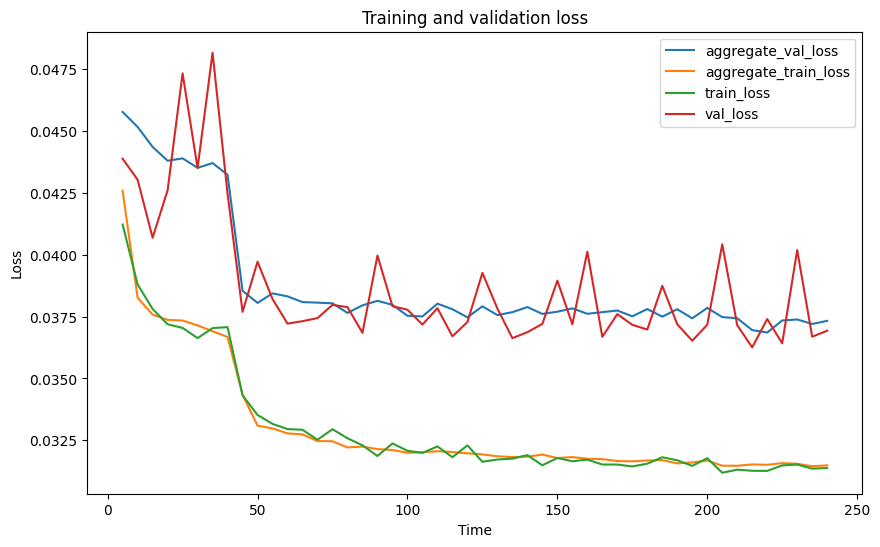

In [ ]:
time = np.arange(5, 241, 5)

fig = plt.figure(figsize=(10, 6))
plt.plot(time, val_loss, label='aggregate_val_loss')
plt.plot(time, train_loss, label='aggregate_train_loss')
plt.plot(time, first_train_loss, label='train_loss')
plt.plot(time, first_val_loss, label='val_loss')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(output_dir / "loss.png")

# **Visualize**

In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

main_dir = '/content/drive/MyDrive/Colab Notebooks/NTC'
%cd $main_dir
!ls

this_dir = Path.cwd()
dir_5s = this_dir / "flower_saved" / "train_5s_48r"
dir_20s = this_dir / "flower_saved" / "train_20s_12r"

/content/drive/MyDrive/Colab Notebooks/NTC
Custom_Flower_FL.ipynb	flower_saved


In [10]:
train_loss_5s_file = str(dir_5s) + '/train_loss.pkl'
train_loss_20s_file = str(dir_20s) + '/train_loss.pkl'
val_loss_5s_file = str(dir_5s) + '/val_loss.pkl'
val_loss_20s_file = str(dir_20s) + '/val_loss.pkl'

In [11]:
with open(train_loss_5s_file, 'rb') as f:
    train_loss_5s = pickle.load(f)

with open(train_loss_20s_file, 'rb') as f:
    train_loss_20s = pickle.load(f)

with open(val_loss_5s_file, 'rb') as f:
    val_loss_5s = pickle.load(f)

with open(val_loss_20s_file, 'rb') as f:
    val_loss_20s = pickle.load(f)

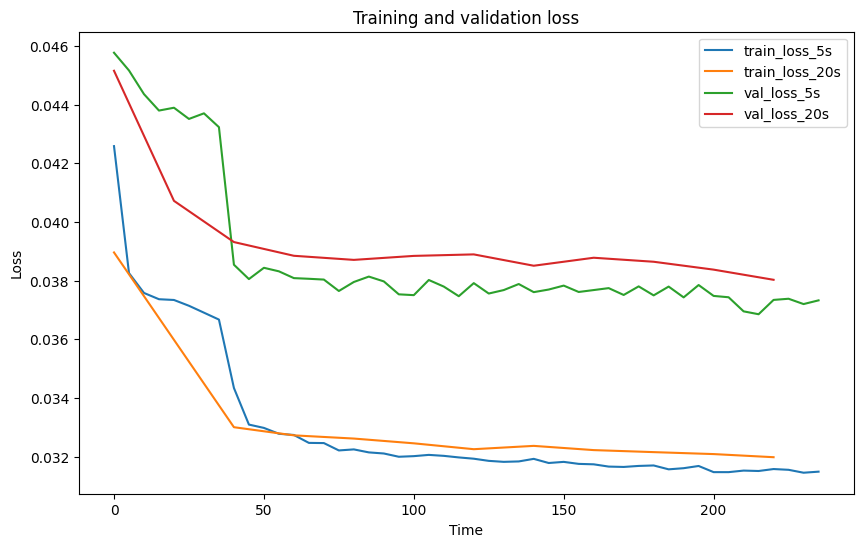

In [14]:
time_5s = np.arange(0, 236, 5)
time_20s = np.arange(0, 221, 20)
output_dir = this_dir / "flower_saved"

fig = plt.figure(figsize=(10, 6))
plt.plot(time_5s, train_loss_5s, label='train_loss_5s')
plt.plot(time_20s, train_loss_20s, label='train_loss_20s')
plt.plot(time_5s, val_loss_5s, label='val_loss_5s')
plt.plot(time_20s, val_loss_20s, label='val_loss_20s')
plt.xlabel('Time')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig(output_dir / "loss.png")